# MCMC simulation of Melbourne water consumption

## Imports

In [90]:
%matplotlib inline
from pymc3 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [49]:
# Water use
x = np.array([300,320,315,330,340,335,290,310,325,330,310,340,355,330,340,350,330,
            340,360,340,360,370,375,340,360,365,380,390,290,345,360,380,375,350,
            410,420,430,425,445,440,495,505,500,390,400,455,445,440,470,450,470,
            465,430,400,400,420,390,440,440,410,415,400,360,370,330])

# Year
year = np.array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 
                1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 
                1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 
                1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 
                1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 
                2000, 2001, 2002, 2003, 2004])
ybar = np.mean(year)
kappa=1980
yearminuskappa = year - kappa

## Specify model

Discrete water consumption data assumed to come from a Poisson distribution: 

$$x_i \sim Poisson(\theta_i)$$

Where where $\theta_i$ is described by a piecewise-continuous linear trend.

$$ \theta_i = \theta_0 + \theta_1(year_i - \overline{year}) + \theta_2 max(year_i - \kappa,0)$$ 

$\kappa = 1980$.

In [83]:
from pymc3.math import maximum

with Model() as model: # model specifications
    # Define priors
    theta0 = Normal('theta0', mu = 0, sd=1e6)
    theta1 = Normal('theta1', mu = 0, sd=1e6)
    theta2 = Normal('theta2', mu = 0, sd=1e6)
    
    theta = theta0 + theta1*(year - ybar) + theta2*maximum(0, yearminuskappa)
    
    # Define likelihood
    likelihood = Poisson('x', mu=theta, observed=x)

    start = {theta0: 150,
             theta1: 1,
             theta2: -1}
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(20000, step, start=start, progressbar=True, njobs=3) 
    # draw 20000 posterior samples, 3 chains.

100%|██████████| 20000/20000 [00:32<00:00, 609.85it/s]


## Convergence

### Gelman rubin

In [84]:
gelman_rubin(trace)

{'theta0': 0.99998768303898322,
 'theta1': 1.000064729493197,
 'theta2': 1.0000677387474353}

$\approx$ 1. So we could have converged.

## Inference

In [87]:
trace_burnin = trace[5000:] # Apply burn in, 5000 samples.
df_summary(trace_burnin, varnames=['theta0', 'theta1', 'theta2'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta0,407.450623,3.704704,0.031814,400.213864,414.688196
theta1,3.603423,0.211315,0.001896,3.202084,4.030679
theta2,-5.302589,0.576907,0.005363,-6.467738,-4.195696


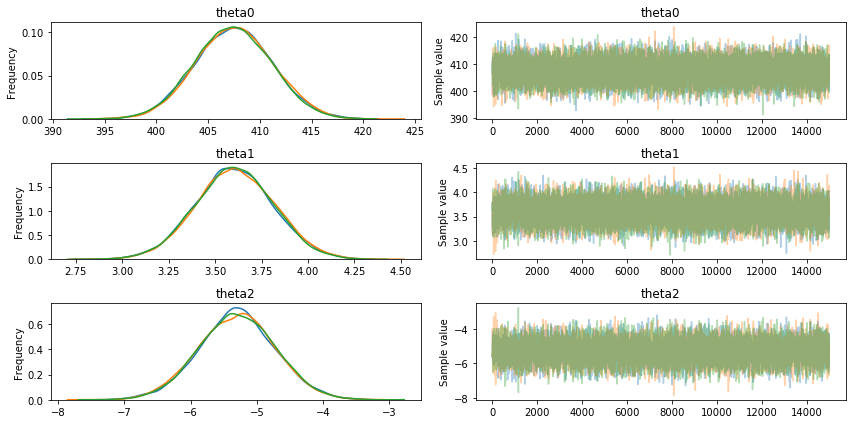

In [88]:
plt.figure(figsize=(3, 3))
traceplot(trace_burnin)
plt.tight_layout()

Since $\theta_1$ describes the slope of the regression line before $\kappa$ = 1980 examining the marginal density estimate reveals that $\theta_1$ is positive and non-zero, we can conclude that there is indeed a (positive) linear trend (as opposed to a constant trend) before the changepoint.

The slope of the linear regression after 1980 is given by $\theta_1 + \theta_2$. Examining the posterior of $\theta_2 + \theta_2$ overall the slope is clearly negative.  We can conclude that there is indeed a (negative) trend after
the changepoint.

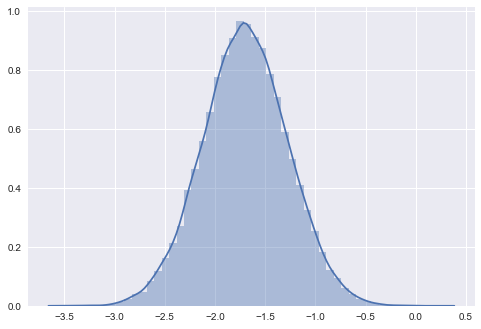

In [91]:
sns.distplot(trace_burnin['theta1']+trace_burnin['theta2'])